In [ ]:
pip install mrcnn

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# import cv2
# import numpy as np
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.preprocessing import image
# from PIL import Image
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications import VGG19
# from mrcnn.config import Config
# from mrcnn import utils
# import mrcnn.model as modellib
# from mrcnn import visualize


# # Object segmentation with Mask R-CNN 
# class ObjectSegmentationConfig(Config):
#   NAME = "coco_pretrained"  
#   IMAGES_PER_GPU = 1
#   NUM_CLASSES = 81  # 80 object classes + 1 background

# config = ObjectSegmentationConfig()
# model = modellib.MaskRCNN(mode="inference", config=config, model_dir='logs')

# # **** IMPORTANT: Replace with the path to your downloaded Mask R-CNN weights file ****
# rcnn_path="/kaggle/input/rcnn-weights/mask_rcnn_coco.h5"
# model.load_weights('/kaggle/input/rcnn-weights/mask_rcnn_coco.h5', by_name=True) 

# # # Load VGG model 
# # vggweights='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop (1).h5'
# # vgg_model = VGG19(weights=vggweights, include_top=False)
# # vgg_model.trainable = False  # Freeze VGG model layers

# # -------- Main Execution --------
# # **** IMPORTANT: Replace with the paths to your image files ****
# image_path = '/kaggle/input/persondog/f0301791-800px-wm.jpg'
# # style_image_path = '/kaggle/input/images111/Paul_Klee_121.jpg' 

# # Load image 
# original_image = cv2.imread(image_path)  
# original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) 

# # Object segmentation with Mask R-CNN
# results = model.detect([original_image], verbose=0)
# r = results[0]  

# # Apply style transfer to detected objects
# styled_image = original_image.copy()

# # Visualize the objects detected by Mask R-CNN
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                              ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                               'bus', 'train', 'truck', 'boat', 'traffic light',
#                               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                               'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                               'teddy bear', 'hair drier', 'toothbrush'])

# # Show the plot
# plt.show()


In [1]:
import tensorflow as tf
tf.enable_eager_execution()

In [2]:
import tensorflow as tf

# Check if eager execution is enabled
if tf.executing_eagerly():
    print("Eager execution is enabled.")
else:
    print("Eager execution is not enabled.")


Eager execution is enabled.


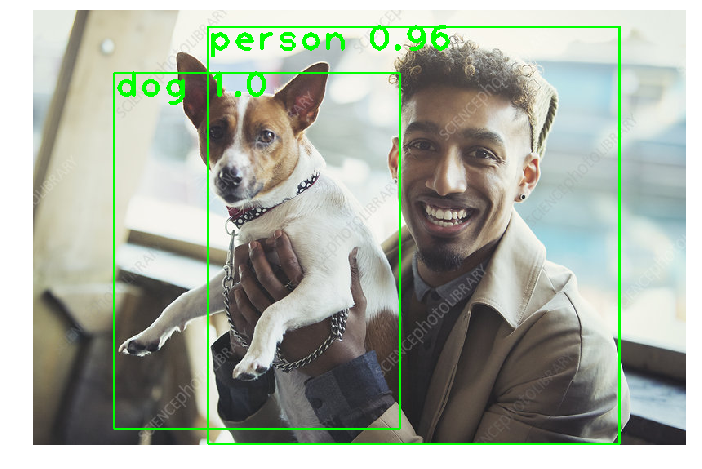

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load YOLO model and class labels
net = cv2.dnn.readNet("/kaggle/input/yolo-coco-data/yolov3.weights", "/kaggle/input/yolo-coco-data/yolov3.cfg")
classes = []
with open("/kaggle/input/yolo-coco-data/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Load image
image_path = '/kaggle/input/persondog/f0301791-800px-wm.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Preprocess image
blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

# Process detections
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * image.shape[1])
            center_y = int(detection[1] * image.shape[0])
            w = int(detection[2] * image.shape[1])
            h = int(detection[3] * image.shape[0])
            # Calculate bounding box coordinates
            x = max(0, int(center_x - w / 2))
            y = max(0, int(center_y - h / 2))
            # Adjust width and height to fit within image boundaries
            w = min(image.shape[1] - x, w)
            h = min(image.shape[0] - y, h)
            # Append adjusted coordinates to boxes list
            boxes.append([x, y, w-1, h-1])  # Adjusted width and height
            confidences.append(float(confidence))
            class_ids.append(class_id)


# Non-maximum suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw bounding boxes and labels
offset = 1 # Adjust this value as needed

# Draw bounding boxes and labels
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]
        color = (0, 255, 0)
        
        # Adjust bounding box coordinates to ensure it stays within the image boundaries
        x1 = max(0, x - offset)
        y1 = max(0, y - offset)
        x2 = min(image.shape[1], x + w - offset)
        y2 = min(image.shape[0], y + h - offset)
        
        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image_rgb, label + " " + str(round(confidence, 2)), (x1, y1 + 30), cv2.FONT_HERSHEY_PLAIN, 3, color, 3)

# Display the result using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()



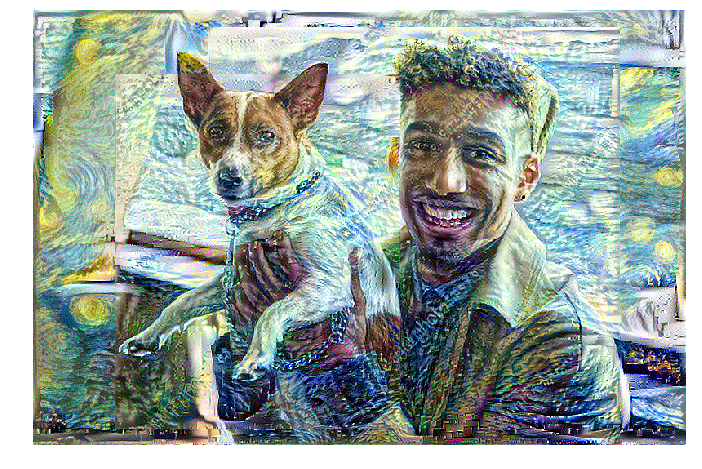

In [52]:
# for i in range(len(boxes)):
#     if i in indexes:
#         x, y, w, h = boxes[i]
#         roi = image[y:y+h, x:x+w]  # Crop the region of interest

#         # Apply style transfer to the cropped object
#         styled_roi = run_style_transfer(roi,style_path)
#         # Replace the original object with the styled object in the original image
#         image[y:y+h, x:x+w] = styled_roi[2][-1]

# # Display the final styled image
# plt.figure(figsize=(12, 8))
# plt.imshow(image)
# plt.axis('off')
# plt.show()

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb_copy = image  # Make a copy of the original RGB image
full_image_transfer = run_style_transfer(image, style_path,epochs=600,content_weight=1e3, style_weight=1e9)
styled_full_image = full_image_transfer[2][-1]  # Get the stylized full image

# Apply style transfer to the entire image
image = styled_full_image

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]

        # Boundary checks
        if  0 <= x < image.shape[1] and \
            0 <= y < image.shape[0] and \
            0 <= x + w <= image.shape[1] and \
            0 <= y + h <= image.shape[0]:

            roi = image_rgb_copy[y:y+h, x:x+w]  # Crop the region of interest

            # Apply style transfer to the cropped object
            styled_roi = run_style_transfer(roi, style_path,epochs=350,content_weight=1e3, style_weight=1e-4)

            # Replace the original object with the styled object in the original image
            image[y:y+h, x:x+w] = styled_roi[2][-1] 

        else:
            print(f"Object at index {i} has a bounding box outside image boundaries. Skipping style transfer.")

# Display the final styled image
plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
# # # Display the final styled image
# # #image_rgb_final = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_rgb_copy = image  # Make a copy of the original RGB image
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


plt.figure(figsize=(12, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

Using TensorFlow backend.


In [46]:
content_path = '/kaggle/input/persondog/f0301791-800px-wm.jpg'
style_path='/kaggle/input/images111/the_starry_night-t2.jpg'

In [47]:
# def load_file(image_path):
#     image =  Image.open(image_path)
#     max_dim=512
#     factor=max_dim/max(image.size)
#     image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
#     im_array = process_im.img_to_array(image)
#     im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a
#                                                #batch of single image

#     return im_array


def load_file(image_path):
    if isinstance(image_path, str):  # Check if image_path is a string (file path)
        image = Image.open(image_path)
    elif isinstance(image_path, Image.Image):  # Check if image_path is a PIL Image object
        image = image_path
    else:
        raise ValueError("Invalid input format. image_path must be a file path or a PIL Image object.")
    
    max_dim = 512
    factor = max_dim / max(image.size)
    image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array, axis=0)  # adding extra axis to the array as to generate a batch of single image

    return im_array


In [48]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

In [49]:
content = load_file(content_path)
style = load_file(style_path)

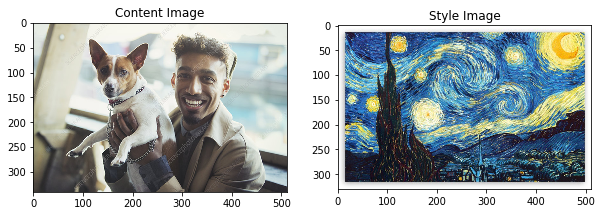

In [50]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

In [19]:
# def img_preprocess(img_path):
#     image=load_file(img_path)
#     img=tf.keras.applications.vgg19.preprocess_input(image)
#     return img

from tensorflow.keras.preprocessing import image as keras_image
import numpy as np
import tensorflow as tf

def img_preprocess(img):
    if isinstance(img, str):  # If the input is a file path
        image = load_file(img)
        #img_processed = tf.keras.preprocessing.image.img_to_(image)
        #img_processed = np.expand_dims(img_processed, axis=0)
        img_processed = tf.keras.applications.vgg19.preprocess_input(image)
    else:  # If the input is a PIL Image object
        img_processed = tf.keras.preprocessing.image.img_to_array(img)
        img_processed = np.expand_dims(img_processed, axis=0)
        img_processed = tf.keras.applications.vgg19.preprocess_input(img_processed)
    return img_processed




In [20]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [21]:
im=img_preprocess(content_path)

In [22]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

In [23]:
def get_model(weights_path='/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop (1).h5'):
    if weights_path is None:
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    else:
        vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights=None)
        vgg.load_weights(weights_path)

    vgg.trainable = False
    content_output = [vgg.get_layer(layer).output for layer in content_layers]
    style_output = [vgg.get_layer(layer).output for layer in style_layers]
    model_output = style_output + content_output

    return tf.keras.models.Model(vgg.input, model_output)


In [24]:
from tensorflow.keras.applications import VGG19

weights_path = '/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

# Load VGG19 model with pre-trained weights from the local file
model = VGG19(weights=weights_path, include_top=False)

# Display model summary
model.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [25]:
model=get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [26]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

In [27]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [28]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss


In [29]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)

    content_output=model(content_img)
    style_output=model(style_image)

    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature


In [30]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image

    output=model(image)
    content_loss=0
    style_loss=0

    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]

    weight_per_layer = 1.0/float(number_style)
    #weight_per_layer = 1.0/float(5)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)


    weight_per_layer =1.0/ float(number_content)
    #weight_per_layer = 1.0/float(5)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)

    style_loss *= style_weight
    content_loss *= content_weight

    total_loss = content_loss + style_loss


    return total_loss,style_loss,content_loss

In [31]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)

    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [32]:
from tensorflow.keras.applications import VGG19

# Replace 'path/to/your/downloaded/file/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5' with the actual path
weights_path = '/kaggle/input/vgg19w/vgg19_weights_tf_dim_ordering_tf_kernels_notop (1).h5'

# Load VGG19 model with pre-trained weights from the local file
model = VGG19(weights=weights_path, include_top=False)


In [33]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [34]:
def run_style_transfer(content_path,style_path,epochs,content_weight, style_weight):

    model=get_model()
    #model = VGG19(weights=weights_path, include_top=False)

    for layer in model.layers:
        layer.trainable = False

    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]

    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    # Initialize best loss and best image
    best_loss = float('inf')
    best_img = None

    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(epochs):
        grad, all_loss = compute_grads(dictionary)
        total_loss, style_loss, content_loss = all_loss
        optimizer.apply_gradients([(grad, noise)])
        clipped = tf.clip_by_value(noise, min_vals, max_vals)
        noise.assign(clipped)

        # Evaluate total_loss as a TensorFlow tensor
        total_loss_value = total_loss.numpy()

        # Compare total_loss with best_loss
        if total_loss_value < best_loss:
            best_loss = total_loss_value
            best_img = deprocess_img(noise.numpy())

        # for visualization
        if i % 50 == 0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))
            print('Total loss: {:.4e}, style loss: {:.4e}, content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    
    IPython.display.clear_output(wait=True)
    return best_img,best_loss,imgs

In [35]:
# best, best_loss,image = run_style_transfer(content_path,
#                                      style_path, epochs=1000)

In [36]:
# # Assuming you already have the necessary functions and variables defined above

# # Object segmentation with Mask R-CNN
# # results = model.detect([original_image], verbose=0)
# # r = results[0]  

# # Apply style transfer to each detected object
# styled_objects = []
# for i in range(r['rois'].shape[0]):
#     # Extract each object using the bounding box coordinates
#     y1, x1, y2, x2 = r['rois'][i]
#     object_image = original_image[y1:y2, x1:x2]

#     # Convert numpy array to PIL Image
#     object_pil_image = Image.fromarray(object_image)

#     # Apply style transfer to the extracted object
#     styled_object, _, _ = run_style_transfer(object_pil_image, style_image_path, epochs=1000)
#     styled_objects.append(styled_object)


# # Combine styled objects back into a single image
# combined_image = original_image.copy()
# for i, styled_object in enumerate(styled_objects):
#     y1, x1, y2, x2 = r['rois'][i]
#     combined_image[y1:y2, x1:x2] = styled_object

# # Visualize or save the final combined image
# plt.imshow(combined_image)
# plt.axis('off')
# plt.show()